### https://github.com/facebookresearch/habitat-sim?tab=readme-ov-file
### https://github.com/facebookresearch/habitat-lab

In [5]:
%matplotlib inline

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import time

# Register ManiSkill2 environments in gym
import mani_skill2.envs

from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.sensors.camera import CameraConfig
from mani_skill2.utils.registration import register_env
from mani_skill2.utils.sapien_utils import look_at
from utils import get_poses_from_instructions, plot_img
from tqdm import tqdm, trange
from IPython.display import display, clear_output

In [ ]:
# Download YCB objects
!python -m mani_skill2.utils.download_asset ycb -y
# Download an example ReplicaCAD scene from Habitat
# You can use other dataset like Gibson or Matterport3D
!wget https://dl.fbaipublicfiles.com/habitat/Gibson/hab2_bench_assets.zip -P data
!cd data && unzip -q hab2_bench_assets.zip -d hab2_bench_assets

In [ ]:
# lets load action trajectories

# git clone https://huggingface.co/datasets/haosulab/ManiSkill2

In [ ]:
# Directly download the converted demonstrations dataset files
import urllib.request
!mkdir -p "demos/v0/rigid_body/LiftCube-v0"
urllib.request.urlretrieve("https://huggingface.co/datasets/haosulab/ManiSkill2/resolve/main/processed_demos/LiftCube-v0.tar.gz", "demos/v0/rigid_body/LiftCube-v0.tar.gz")
!tar -xvzf "demos/v0/rigid_body/LiftCube-v0.tar.gz" -C "demos/v0/rigid_body/"

LiftCube-v0/
LiftCube-v0/trajectory.json
LiftCube-v0/trajectory.state.pd_ee_delta_pose.h5
LiftCube-v0/trajectory.state.pd_ee_delta_pose.json
LiftCube-v0/trajectory.rgbd.pd_ee_delta_pose.json
LiftCube-v0/trajectory.h5
LiftCube-v0/trajectory.rgbd.pd_ee_delta_pose.h5


In [6]:
import h5py
from mani_skill2.utils.io_utils import load_json


def load_h5_data(data):
    out = dict()
    for k in data.keys():
        if isinstance(data[k], h5py.Dataset):
            out[k] = data[k][:]
        else:
            out[k] = load_h5_data(data[k])
    return out


env_id = "StackCube-v0"
# dataset_file = f"demos/v0/rigid_body/{env_id}/trajectory.rgbd.pd_ee_delta_pose.h5"
# dataset_file = f"ManiSkill2/demos/v0/rigid_body/{env_id}/trajectory.h5"
dataset_file = f"ManiSkill2/demos/v0/rigid_body/PushChair-v1/3001/trajectory.h5"

data = h5py.File(dataset_file, "r")
json_path = dataset_file.replace(".h5", ".json")
json_data = load_json(json_path)
episodes = json_data["episodes"]
env_info = json_data["env_info"]
env_id = env_info["env_id"]
env_kwargs = env_info["env_kwargs"]
env_kwargs['obs_mode'] = "rgbd"

In [9]:
env = gym.make(env_info["env_id"], camera_cfgs={"add_segmentation": True}, **env_info["env_kwargs"])

for e in trange(len(episodes)):
    eps = episodes[e]
    trajectory = data[f"traj_{eps['episode_id']}"]
    trajectory = load_h5_data(trajectory)

    obs, _ = env.reset()
    env_state = trajectory["env_states"][0]
    env.set_state(env_state)
    actions = trajectory['actions']

# for i in tqdm(range(actions.shape[0])):
    # obs, reward, terminated, truncated, info = env.step(actions[i])

    clear_output(wait=True)
    plt.imshow(env.unwrapped.render_rgb_array())
    # plt.savefig(f"test_data/augmentation_examples/stack_cube_{e}.png")
    plt.show()

 22%|██▏       | 66/300 [00:08<00:30,  7.77it/s]


KeyboardInterrupt: 

In [3]:
# different scenes

import sapien.core as sapien

from mani_skill2 import ASSET_DIR
from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.sensors.camera import CameraConfig
from mani_skill2.utils.registration import register_env
from mani_skill2.utils.sapien_utils import look_at


IMG_WIDTH = 1024
IMG_HEIGHT = 1024
def build_habitat_scene(poses, offset_value=None):
    @register_env("PickSingleYCB-v0", max_episode_steps=200, override=True)
    class PickSingleYCB(PickCubeEnv):
        def _load_actors(self):
            # Load YCB objects
            # It is the same as in PickSingleYCB-v0, just for illustration here
            builder = self._scene.create_actor_builder()
            model_dir = ASSET_DIR / "mani_skill2_ycb/models/011_banana"
            scale = self.cube_half_size / 0.01887479572529618
            collision_file = str(model_dir / "collision.obj")
            builder.add_multiple_collisions_from_file(
                filename=collision_file, scale=scale, density=1000
            )
            visual_file = str(model_dir / "textured.obj")
            builder.add_visual_from_file(filename=visual_file, scale=scale)
            self.obj = builder.build(name="apple")

            # Add a goal indicator (visual only)
            self.goal_site = self._build_sphere_site(self.goal_thresh)

            # -------------------------------------------------------------------------- #
            # Load static scene
            # -------------------------------------------------------------------------- #
            builder = self._scene.create_actor_builder()
            path = f"{ASSET_DIR}/hab2_bench_assets/stages/Baked_sc1_staging_00.glb"
            pose = sapien.Pose(q=[0.707, 0.707, 0, 0])  # y-axis up for Habitat scenes
            # NOTE: use nonconvex collision for static scene
            builder.add_nonconvex_collision_from_file(path, pose)
            builder.add_visual_from_file(path, pose)
            self.arena = builder.build_static()
            # Add offset so that the workspace is on the table
            offset = np.array([-2.0616 + offset_value, -3.1837, 0.66467 + 0.095])
            self.arena.set_pose(sapien.Pose(-offset))

        def initialize_episode(self):
            super().initialize_episode()

            # Rotate the robot for better visualization
            self.agent.robot.set_pose(
                sapien.Pose([0, -0.56, 0], [0.707, 0, 0, 0.707])
            )

        def _register_render_cameras(self):
            cam_cfg = super()._register_render_cameras()
            cam_cfg.p = cam_cfg.p + [0.5, 0.5, -0.095]
            cam_cfg.fov = 1.5
            return cam_cfg

        def _register_cameras(self):
            cameras = []
            for i in range(len(poses)):
                scene_camera = CameraConfig(
                    f"camera_{i}", poses[i].p, poses[i].q, IMG_WIDTH, IMG_HEIGHT, 1, 0.01, 10
                )
                cameras.append(scene_camera)
            return cameras


    env = gym.make("PickSingleYCB-v0", obs_mode="rgbd", camera_cfgs={"add_segmentation": True})
    obs, _ = env.reset()
    
    episode = episodes[0]
    env.reset(**episode["reset_kwargs"])
    plot_img(env.unwrapped.render_rgb_array())
    episode = episodes[len(episodes) // 2]
    env.reset(**episode["reset_kwargs"])
    plot_img(env.unwrapped.render_rgb_array())
    episode = episodes[-1]
    env.reset(**episode["reset_kwargs"])
    plot_img(env.unwrapped.render_rgb_array())
    env.close()
    del env
    return obs

In [12]:
def test(object_dir_path):
    @register_env("PickSingleYCB-v0", max_episode_steps=200, override=True)
    class PickSingleYCB(PickCubeEnv):
        def _load_actors(self):
            # Load YCB objects
            # It is the same as in PickSingleYCB-v0, just for illustration here
            builder = self._scene.create_actor_builder()
            model_dir = ASSET_DIR / object_dir_path
            scale = self.cube_half_size / 0.01887479572529618
            collision_file = str(model_dir / "collision.obj")
            builder.add_multiple_collisions_from_file(
                filename=collision_file, scale=scale, density=1000
            )
            visual_file = str(model_dir / "textured.obj")
            builder.add_visual_from_file(filename=visual_file, scale=scale)
            self.obj = builder.build(name="apple")

            # Add a goal indicator (visual only)
            self.goal_site = self._build_sphere_site(self.goal_thresh)

            # -------------------------------------------------------------------------- #
            # Load static scene
            # -------------------------------------------------------------------------- #
            builder = self._scene.create_actor_builder()
            path = f"{ASSET_DIR}/hab2_bench_assets/stages/Baked_sc1_staging_00.glb"
            pose = sapien.Pose(q=[0.707, 0.707, 0, 0])  # y-axis up for Habitat scenes
            # NOTE: use nonconvex collision for static scene
            builder.add_nonconvex_collision_from_file(path, pose)
            builder.add_visual_from_file(path, pose)
            self.arena = builder.build_static()
            # Add offset so that the workspace is on the table
            offset = np.array([-2.0616, -3.1837, 0.66467 + 0.095])
            self.arena.set_pose(sapien.Pose(-offset))

        def initialize_episode(self):
            super().initialize_episode()

            # Rotate the robot for better visualization
            self.agent.robot.set_pose(
                sapien.Pose([0, -0.56, 0], [0.707, 0, 0, 0.707])
            )

        def _register_render_cameras(self):
            cam_cfg = super()._register_render_cameras()
            cam_cfg.p = cam_cfg.p + [0.5, 0.5, -0.095]
            cam_cfg.fov = 1.5
            return cam_cfg

    env = gym.make("PickSingleYCB-v0", obs_mode="rgbd", camera_cfgs={"add_segmentation": True})
    obs, _ = env.reset()
    plot_img(env.unwrapped.render_rgb_array())


2024-03-04 13:42:31,336 - mani_skill2 - WARNING - Override registered env PickSingleYCB-v0
[2024-03-04 13:42:31.337] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


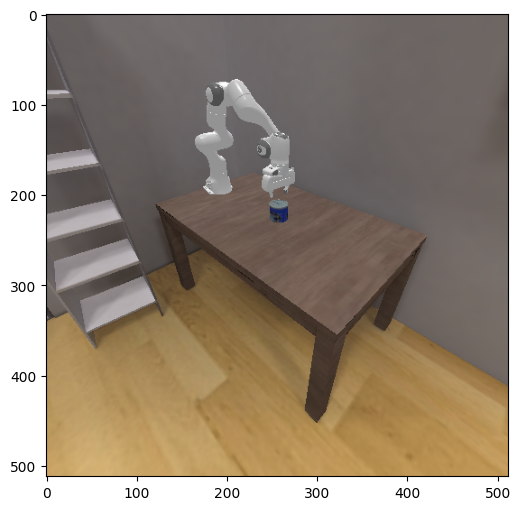

In [14]:
# test("mani_skill2_ycb/models/011_banana")
test("mani_skill2_ycb/models/002_master_chef_can")

In [119]:
initial_position = [5, -1, 0.5]
initial_target = [0, 0, 0.5]

instructions = [
    ["left", "angle", 30],
    ["down", "angle", 10],
    ["right", "angle", 30],
    ["up", "angle", 10],
    ["forward", "distance", 1],
    ["backward", "distance", 2],
    ["forward", "distance", 1],
    ["forward", "distance", 1]
]

# poses = get_poses_from_instructions(initial_position, initial_target, instructions)

poses = [look_at([i, j, 0], [0, 0, 0.5]) for i, j in zip(range(0, 5), range(0, 5))]

In [121]:
episode["reset_kwargs"]


{'seed': 99}

2024-02-19 21:23:02,366 - mani_skill2 - WARNING - Override registered env PickSingleYCB-v0
[2024-02-19 21:23:02.367] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


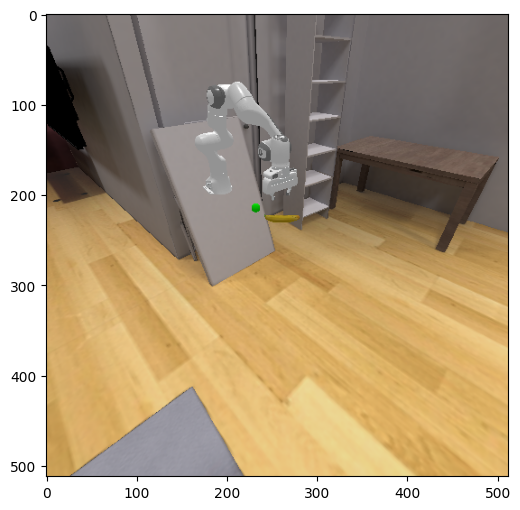

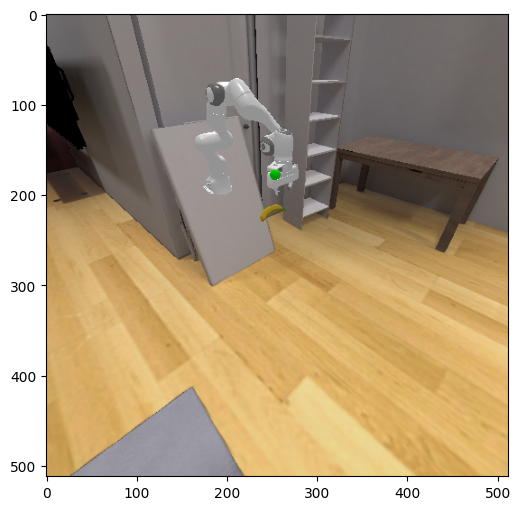

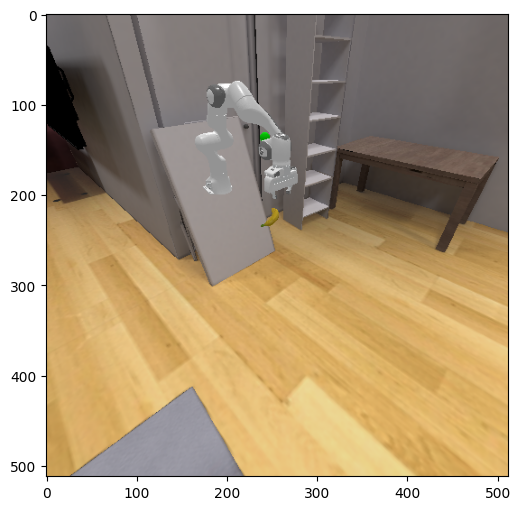

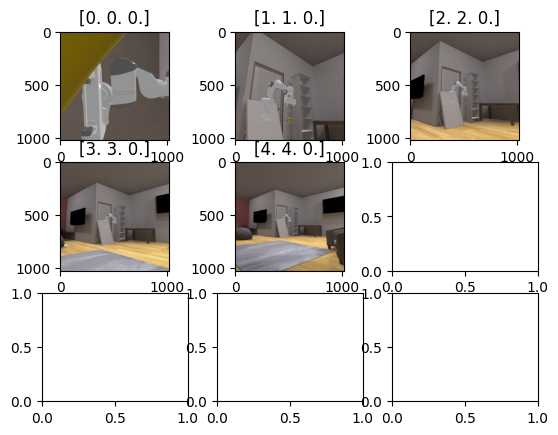

In [120]:
obs = build_habitat_scene(poses, 2)
fig, axs = plt.subplots(3, 3)

for i in range(len(poses)):
    scene_camera = obs['image'][f'camera_{i}']['rgb']
    axs.flatten()[i].imshow(scene_camera)
    axs.flatten()[i].set_title(poses[i].p)
plt.show()

In [92]:
obs['state'].shape

(91, 32)

In [77]:
# now how do we import this into the environment

# we can use the `env.set_state` method to set the state of the environment
# we can use the `env.step` method to apply the actions to the environment

array([ 2.9802322e-06, -1.4342368e-05, -6.1094761e-05, -0.0000000e+00,
        0.0000000e+00, -0.0000000e+00,  1.0000000e+00], dtype=float32)

In [98]:
env_info

{'env_id': 'LiftCube-v0',
 'max_episode_steps': 200,
 'env_kwargs': {'obs_mode': 'rgbd', 'control_mode': 'pd_ee_delta_pose'}}

[2024-02-19 20:27:28.980] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


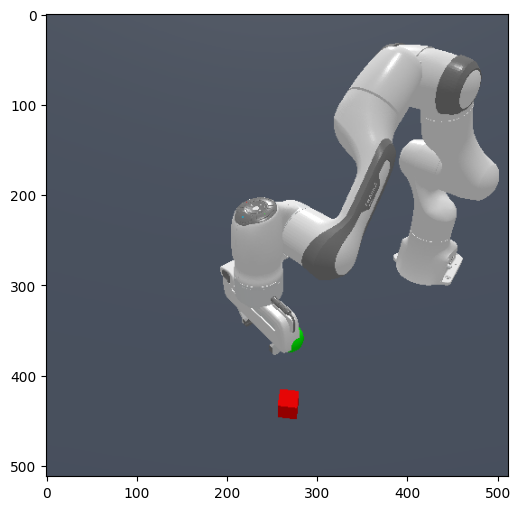

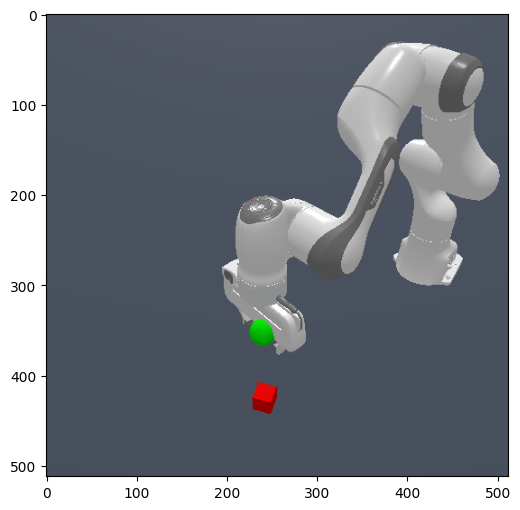

In [102]:
env = gym.make(env_info["env_id"], **env_info["env_kwargs"])


In [113]:
import sapien.core as sapien

from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.utils.registration import register_env


@register_env("DR-PickCube-v1", max_episode_steps=100, override=True)
class DomainRandomizationPickCubeEnvV1(PickCubeEnv):
    # Reconfigure the environment when reset by default
    def reset(self, seed=None, options=None):
        return super().reset(seed, options=dict(reconfigure=True))

    def _load_actors(self):
        self.cube_half_size = self._episode_rng.uniform(0.01, 0.03, size=3)
        super()._load_actors()


env = gym.make("DR-PickCube-v1")
for _ in range(3):
    env.reset()
    env.set_state(obs['state'][0])
    plot_img(env.unwrapped.render_rgb_array())
env.close()
del env

2024-02-19 21:19:47,773 - mani_skill2 - WARNING - Override registered env DR-PickCube-v1
[2024-02-19 21:19:47.774] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.set_state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_state` for environment variables or `env.get_wrapper_attr('set_state')` that will search the reminding wrappers.
  logger.warn(


KeyError: 'state'

In [95]:
obs['state'][0].shape

(32,)